In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from scipy.spatial.distance import cdist

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
X=np.load("Features.npy")
y=np.load("Labels.npy")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=100, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=100, random_state=42)

In [29]:
print(X.shape)
print(np.unique_counts(y))

(1000, 2)
UniqueCountsResult(values=array([0, 1, 2, 3]), counts=array([100, 400, 100, 400]))


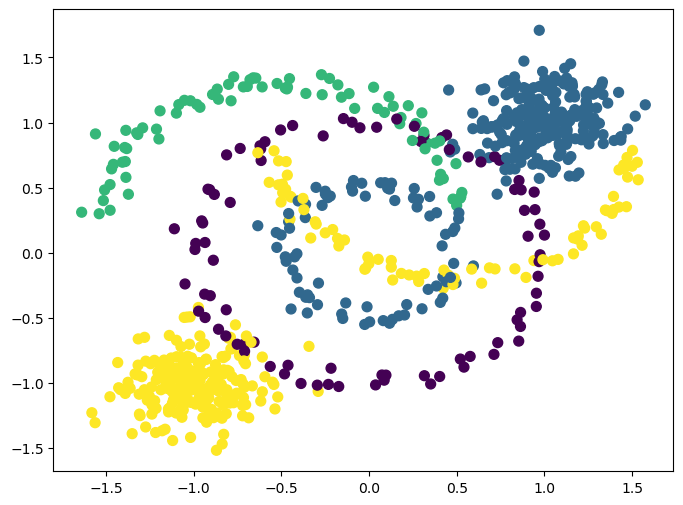

In [30]:
plt.figure(figsize=(8, 6))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=50, cmap='viridis')

In [31]:
# Helper Functions (can be used)

from colorsys import hls_to_rgb

def get_distinct_colors(n):

    colors = []

    for i in np.arange(0., 360., 360. / n):
        h = i / 360.
        l = (50 + np.random.rand() * 10) / 100.
        s = (90 + np.random.rand() * 10) / 100.
        colors.append([hls_to_rgb(h, l, s)[0],hls_to_rgb(h, l, s)[1], hls_to_rgb(h, l, s)[2]] )

    return np.array(colors)

def determineClusterColors(clusters, k, f):
    colors=get_distinct_colors(k)
    clusterColor=[]

    for p in clusters:

        if p[1]==0:
            clusterColor.append(colors[p[0]])
        else:
            scalar=(p[1])*f
            color=colors[p[0]]+scalar

            color=np.where(color>0.99,0.99,color)
            clusterColor.append(color)
    return clusterColor

def classifyCluster(x, cluster):
    N=x.shape[0]

    clusters=[]
    for i in range(N):
        distance=np.linalg.norm(np.power(x[i,:]-cluster,2), axis=1)
        minArg=np.argmin(distance)
        clusters.append([minArg, distance[minArg]])

    return clusters

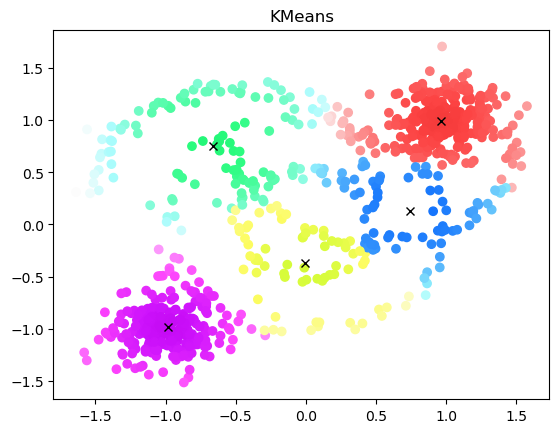

In [32]:
# K-Means Example
num_centroids = 5
kmeans = KMeans(n_clusters=num_centroids, random_state=42)
kmeans.fit(X)
centroids = kmeans.cluster_centers_

clusters=classifyCluster(X_train, centroids)
colors=determineClusterColors(clusters, num_centroids, 1)
plt.scatter(X_train[:, 0], X_train[:, 1], c=colors)
plt.title("KMeans")
for i,c in enumerate(centroids):
    plt.plot(c[0], c[1], marker="x", ls="", c="black")

In [52]:
# TODO: Implement Laplacian Embedding
# X = (x_1, ..., x_n) 2d point is a vertex
# compute Laplacian matrix

def rbf_kernel(X1, X2, gamma):
    diff = X1[:, np.newaxis, :] - X2[np.newaxis, :, :]
    squared_dist = np.sum(diff ** 2, axis=2)
    return np.exp(-gamma * squared_dist)

A = rbf_kernel(X_train, X_train, gamma=15.0)
D = np.diag(np.sum(A, axis=1))
L = D - A

eigenvalues, eigenvectors = np.linalg.eigh(L)
k = 4
F = eigenvectors[:, 1:k+1]

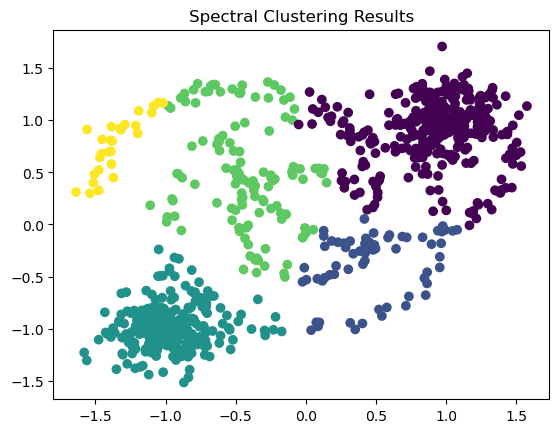

In [61]:
# TODO: Use the implementation of the laplacian embedding and apply k-means to the transformed data (You are allowed to use the sklearn)
num_centroids = 5
kmeans = KMeans(n_clusters=num_centroids, random_state=42)
kmeans.fit(F)
centroids = kmeans.cluster_centers_
clusters = kmeans.labels_

plt.scatter(X_train[:, 0], X_train[:, 1], c=clusters, cmap='viridis')
plt.title("Spectral Clustering Results")
plt.show()

In [58]:
# TODO: Apply logistic regression on the transformed data (laplacian embedding) and solve the classification task. 
# softmax regression model
def layer(x, w):
    N = x.shape[0]
    x_with_bias = np.hstack((np.ones((N, 1), dtype=x.dtype), x))  
    res = np.dot(x_with_bias, w)  
    return res

def softmax(y):
    y_stable = y - np.max(y, axis=1, keepdims=True)
    res = np.exp(y_stable) / np.sum(np.exp(y_stable), axis=1, keepdims=True)
    return res

def model(x, w):
    logits = layer(x, w)       
    probs = softmax(logits)    
    res = np.argmax(probs, axis=1) 
    return res

def classTensor(y, C):
    N = len(y)
    res = np.zeros((N, C), dtype=int)
    res[np.arange(N), y] = 1
    return res

def gradientDescent(x, y, w, learningRate):
    logits = layer(x, w)       
    probs = softmax(logits)    
    y_one_hot = classTensor(y, w.shape[1])  

    x_bias = np.hstack([np.ones((x.shape[0], 1)), x])  

    grad = np.dot(x_bias.T, (probs - y_one_hot)) / x.shape[0]  # (M+1, C)

    w_new = w - learningRate * grad
    return w_new

In [62]:
C = len(np.unique(y_train))  
N, M = F.shape               

np.random.seed(42)
w = np.random.randn(M+1, C) * 0.01

epochs = 1000
learningRate = 0.1

for epoch in range(epochs):
    w = gradientDescent(F, y_train, w, learningRate)
    y_pred = model(F, w)
    acc = accuracy_score(y_train, y_pred)
    if epoch % 200 == 0:
        print(f"Epoch {epoch}, Training Accuracy: {acc:.4f}")

y_pred = model(F, w)
acc_train = accuracy_score(y_train, y_pred)
print(f"Final Training Accuracy: {acc_train:.4f}")

Epoch 0, Training Accuracy: 0.3950
Epoch 200, Training Accuracy: 0.6963
Epoch 400, Training Accuracy: 0.6875
Epoch 600, Training Accuracy: 0.6825
Epoch 800, Training Accuracy: 0.6787
Final Training Accuracy: 0.6763
